# ANÁLISIS DE CLUSTERING MEJORADO PARA PERFILES DE VIAJERO

In [1]:
"""
=============================================================================
ANÁLISIS DE CLUSTERING MEJORADO PARA PERFILES DE VIAJERO
=============================================================================

Este código analiza datos turísticos para identificar automáticamente 
diferentes tipos de viajeros basándose en sus patrones de comportamiento.


Autor: Sistema de Análisis Turístico
Fecha: 2021
=============================================================================
"""

# =============================================================================
# PASO 1: IMPORTAR HERRAMIENTAS NECESARIAS
# =============================================================================


import pandas as pd                 # Para trabajar con tablas de datos
import numpy as np                  # Para operaciones matemáticas
import matplotlib.pyplot as plt     # Para crear gráficos
import seaborn as sns              # Para gráficos más bonitos
import warnings                     # Para ocultar advertencias molestas
warnings.filterwarnings('ignore')   # Las advertencias no son errores, solo avisos

# Herramientas de Machine Learning para clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats

# Configurar estilo visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Herramientas cargadas correctamente")
print("="*70)



✅ Herramientas cargadas correctamente


In [2]:
# =============================================================================
# PASO 2: CONFIGURACIÓN CENTRALIZADA
# =============================================================================


CONFIG = {
    'data': {
        'path': 'datos_INE_consolidados_17112025.csv',
        'min_viajeros': 1000,        # Filtrar combinaciones con pocos datos
        'paises_excluir': [          # Categorías agregadas que duplicarían info
            'Total', 
            'Extranjeros', 
            'Unión Europea (sin España)',
            'Resto de la UE'
        ]
    },
    'clustering': {
        'k_range': range(2, 8),      # Probar entre 2 y 7 grupos
        'random_state': 42,          # Para resultados reproducibles
        'n_init': 20,                # Intentos para encontrar mejor agrupación
    },
    'features': [                    # Características que usaremos
        'media_pernoctaciones_mean',
        'estancia_relativa',
        'volumen_relativo',
        'variabilidad_estancia',
        'intensidad_visitas',
        'concentracion_estacional',
        'mes_sin',
        'mes_cos'
    ]
}

print("⚙️ Configuración cargada:")
print(f"   - Rango de clusters a probar: {CONFIG['clustering']['k_range']}")
print(f"   - Mínimo de viajeros por segmento: {CONFIG['data']['min_viajeros']}")
print(f"   - Características a analizar: {len(CONFIG['features'])}")
print("="*70)


⚙️ Configuración cargada:
   - Rango de clusters a probar: range(2, 8)
   - Mínimo de viajeros por segmento: 1000
   - Características a analizar: 8


In [3]:
# =============================================================================
# PASO 3: CARGAR Y EXPLORAR DATOS
# =============================================================================


print("\n📂 CARGANDO DATOS...")

try:
    df = pd.read_csv(CONFIG['data']['path'])
    print(f"✅ Datos cargados: {len(df):,} registros")
    print(f"   Columnas disponibles: {list(df.columns)}")
    print(f"\n📊 Primeros registros:")
    print(df.head(3))
    
    # Verificar calidad de datos
    print(f"\n🔍 CALIDAD DE DATOS:")
    print(f"   - Valores nulos: {df.isnull().sum().sum()}")
    print(f"   - Países únicos: {df['pais_residencia'].nunique()}")
    print(f"   - Provincias únicas: {df['provincia'].nunique()}")
    
except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el archivo {CONFIG['data']['path']}")
    print("   Por favor, verifica la ruta del archivo.")
    exit()
except Exception as e:
    print(f"❌ ERROR al cargar datos: {e}")
    exit()

print("="*70)



📂 CARGANDO DATOS...
✅ Datos cargados: 17,052 registros
   Columnas disponibles: ['año', 'mes', 'provincia', 'pais_residencia', 'pernoctaciones', 'total_viajeros', 'media_pernoctaciones', 'fecha']

📊 Primeros registros:
    año      mes       provincia pais_residencia  pernoctaciones  \
0  2015    Enero  Islas Baleares           Total         25933.0   
1  2015  Febrero  Islas Baleares           Total         30280.0   
2  2015    Marzo  Islas Baleares           Total         46156.0   

   total_viajeros  media_pernoctaciones       fecha  
0          3705.0                  7.00  2015-01-01  
1          4382.0                  6.91  2015-02-01  
2          6536.0                  7.06  2015-03-01  

🔍 CALIDAD DE DATOS:
   - Valores nulos: 0
   - Países únicos: 30
   - Provincias únicas: 7


In [4]:
# =============================================================================
# PASO 4: PREPARACIÓN DE DATOS (DATA CLEANING)
# =============================================================================


print("\n🧹 PREPARANDO DATOS...")

# Verificar columnas necesarias
columnas_requeridas = ['pais_residencia', 'provincia', 'media_pernoctaciones', 'total_viajeros', 'pernoctaciones']
columnas_faltantes = [col for col in columnas_requeridas if col not in df.columns]

if columnas_faltantes:
    print(f"❌ ERROR: Faltan columnas requeridas: {columnas_faltantes}")
    print("   El archivo debe contener las columnas necesarias para el análisis.")
    exit()

# 4.1: Filtrar categorías agregadas (evitar duplicación)
df_filtrado = df[~df['pais_residencia'].isin(CONFIG['data']['paises_excluir'])].copy()
print(f"✅ Filtrados países agregados: {len(df)} → {len(df_filtrado)} registros")

# 4.2: Agrupar por país-provincia (crear perfiles únicos)
df_perfiles = df_filtrado.groupby(['pais_residencia', 'provincia']).agg({
    'media_pernoctaciones': ['mean', 'std', 'min', 'max'],
    'total_viajeros': ['sum', 'mean'],
    'pernoctaciones': 'sum',
    'mes': 'count'
}).round(3)

# Aplanar nombres de columnas (de multi-nivel a simple)
df_perfiles.columns = ['_'.join(col).strip() for col in df_perfiles.columns.values]
df_perfiles = df_perfiles.reset_index()

print(f"✅ Perfiles creados: {len(df_perfiles)} combinaciones país-provincia")

# 4.3: Filtrar perfiles con datos suficientes
df_perfiles = df_perfiles[df_perfiles['total_viajeros_sum'] > CONFIG['data']['min_viajeros']]
print(f"✅ Filtrado por volumen mínimo: {len(df_perfiles)} perfiles válidos")

if len(df_perfiles) == 0:
    print("❌ ERROR: No hay perfiles válidos después del filtrado.")
    print("   Considera reducir el valor de 'min_viajeros' en la configuración.")
    exit()

print("="*70)




🧹 PREPARANDO DATOS...
✅ Filtrados países agregados: 17052 → 15120 registros
✅ Perfiles creados: 182 combinaciones país-provincia
✅ Filtrado por volumen mínimo: 181 perfiles válidos


In [5]:
# =============================================================================
# PASO 5: FEATURE ENGINEERING (Crear variables útiles)
# =============================================================================


print("\n🔧 CREANDO CARACTERÍSTICAS AVANZADAS...")

# 5.1: Métricas relativas (normalización contextual)
df_perfiles['estancia_relativa'] = (
    df_perfiles['media_pernoctaciones_mean'] / 
    df_perfiles['media_pernoctaciones_mean'].mean()
)

df_perfiles['volumen_relativo'] = (
    df_perfiles['total_viajeros_sum'] / 
    df_perfiles['total_viajeros_sum'].mean()
)

# 5.2: Coeficiente de variación (consistencia)
df_perfiles['variabilidad_estancia'] = (
    df_perfiles['media_pernoctaciones_std'] / 
    (df_perfiles['media_pernoctaciones_mean'] + 0.001)  # +0.001 evita división por cero
)

# 5.3: Intensidad de visitas
df_perfiles['intensidad_visitas'] = (
    df_perfiles['total_viajeros_sum'] / 
    df_perfiles['mes_count']
)

# 5.4: Identificar mes más popular
def encontrar_mes_pico(row):
    """Encuentra el mes con más viajeros para cada perfil"""
    datos_perfil = df_filtrado[
        (df_filtrado['pais_residencia'] == row['pais_residencia']) &
        (df_filtrado['provincia'] == row['provincia'])
    ]
    if len(datos_perfil) > 0:
        return datos_perfil.groupby('mes')['total_viajeros'].sum().idxmax()
    return 'Enero'

df_perfiles['mes_mas_probable'] = df_perfiles.apply(encontrar_mes_pico, axis=1)

# 5.5: Concentración estacional
def calcular_concentracion(row):
    """Mide cuánto se concentran las visitas en temporada alta"""
    datos_perfil = df_filtrado[
        (df_filtrado['pais_residencia'] == row['pais_residencia']) &
        (df_filtrado['provincia'] == row['provincia'])
    ]
    if len(datos_perfil) > 0 and row['total_viajeros_sum'] > 0:
        max_viajeros = datos_perfil.groupby('mes')['total_viajeros'].sum().max()
        return max_viajeros / row['total_viajeros_sum']
    return 0

df_perfiles['concentracion_estacional'] = df_perfiles.apply(calcular_concentracion, axis=1)

# 5.6: Encoding circular de meses (técnica avanzada)
meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
               'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
mes_a_num = {mes: i for i, mes in enumerate(meses_orden)}
df_perfiles['mes_num'] = df_perfiles['mes_mas_probable'].map(mes_a_num).fillna(0)

# Convertir mes a coordenadas circulares (sin/cos)
df_perfiles['mes_sin'] = np.sin(2 * np.pi * df_perfiles['mes_num'] / 12)
df_perfiles['mes_cos'] = np.cos(2 * np.pi * df_perfiles['mes_num'] / 12)

print("✅ Características creadas:")
print("   - Métricas relativas (estancia, volumen)")
print("   - Variabilidad e intensidad")
print("   - Concentración estacional")
print("   - Encoding temporal (sin/cos)")
print("="*70)



🔧 CREANDO CARACTERÍSTICAS AVANZADAS...
✅ Características creadas:
   - Métricas relativas (estancia, volumen)
   - Variabilidad e intensidad
   - Concentración estacional
   - Encoding temporal (sin/cos)


In [6]:
# =============================================================================
# PASO 6: DETECCIÓN Y TRATAMIENTO DE OUTLIERS
# =============================================================================


print("\n🎯 DETECTANDO OUTLIERS...")

def detectar_outliers_iqr(df, columnas, umbral=1.5):
    """
    Detecta valores extremos usando el método IQR (Rango Intercuartílico)
    """
    outliers_mask = pd.Series([False] * len(df), index=df.index)
    
    for col in columnas:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            if IQR > 0:  # Solo si hay variación
                limite_inferior = Q1 - umbral * IQR
                limite_superior = Q3 + umbral * IQR
                
                outliers_col = (df[col] < limite_inferior) | (df[col] > limite_superior)
                outliers_mask = outliers_mask | outliers_col
                
                print(f"   - {col}: {outliers_col.sum()} outliers detectados")
    
    return outliers_mask

# Detectar outliers en variables clave
columnas_verificar = ['media_pernoctaciones_mean', 'volumen_relativo', 'variabilidad_estancia']
outliers_mask = detectar_outliers_iqr(df_perfiles, columnas_verificar)

print(f"\n📊 Total de outliers: {outliers_mask.sum()} ({outliers_mask.sum()/len(df_perfiles)*100:.1f}%)")

# Guardar outliers para análisis posterior
df_outliers = df_perfiles[outliers_mask].copy()

# Crear dataset limpio (sin outliers extremos)
df_limpio = df_perfiles[~outliers_mask].copy()

print(f"✅ Dataset limpio: {len(df_limpio)} perfiles")
print(f"   (Se guardaron {len(df_outliers)} outliers para análisis separado)")

if len(df_limpio) < 5:
    print("⚠️ ADVERTENCIA: Muy pocos datos después de eliminar outliers")
    print("   Considera ajustar el umbral de outliers o usar todos los datos")
    df_limpio = df_perfiles.copy()

print("="*70)




🎯 DETECTANDO OUTLIERS...
   - media_pernoctaciones_mean: 6 outliers detectados
   - volumen_relativo: 24 outliers detectados
   - variabilidad_estancia: 10 outliers detectados

📊 Total de outliers: 37 (20.4%)
✅ Dataset limpio: 144 perfiles
   (Se guardaron 37 outliers para análisis separado)


In [7]:
# =============================================================================
# PASO 7: ESCALADO DE VARIABLES
# =============================================================================


print("\n📏 ESCALANDO VARIABLES...")

# Verificar que tenemos las características necesarias
features_disponibles = [f for f in CONFIG['features'] if f in df_limpio.columns]
features_faltantes = [f for f in CONFIG['features'] if f not in df_limpio.columns]

if features_faltantes:
    print(f"⚠️ ADVERTENCIA: Faltan características: {features_faltantes}")
    print(f"   Características disponibles: {features_disponibles}")

if len(features_disponibles) < 3:
    print("❌ ERROR: No hay suficientes características para clustering")
    print("   Se necesitan al menos 3 características diferentes")
    exit()

# Seleccionar features para clustering
X = df_limpio[features_disponibles].copy()

print(f"📊 Estadísticas ANTES del escalado:")
print(X.describe().round(2))

# Usar RobustScaler (más resistente a outliers que StandardScaler)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Variables escaladas con RobustScaler")
print(f"   Dimensiones: {X_scaled.shape}")
print("="*70)




📏 ESCALANDO VARIABLES...
📊 Estadísticas ANTES del escalado:
       media_pernoctaciones_mean  estancia_relativa  volumen_relativo  \
count                     144.00             144.00            144.00   
mean                        4.47               0.95              0.24   
std                         1.58               0.33              0.26   
min                         1.45               0.31              0.01   
25%                         3.23               0.68              0.05   
50%                         4.43               0.94              0.13   
75%                         5.45               1.15              0.35   
max                         8.86               1.87              1.21   

       variabilidad_estancia  intensidad_visitas  concentracion_estacional  \
count                 144.00              144.00                    144.00   
mean                    0.71              668.44                      0.19   
std                     0.25              735.1


🔍 BUSCANDO NÚMERO ÓPTIMO DE CLUSTERS...
   k=2: Silhouette=0.303, DB=1.358, CH=60
   k=3: Silhouette=0.249, DB=1.325, CH=51
   k=4: Silhouette=0.246, DB=1.265, CH=51
   k=5: Silhouette=0.259, DB=1.195, CH=50
   k=6: Silhouette=0.253, DB=1.196, CH=46
   k=7: Silhouette=0.250, DB=1.274, CH=44

✅ Gráfico guardado: 'metricas_clustering.png'

🎯 RECOMENDACIONES POR MÉTRICA:
   - Mejor por Silhouette: k=2
   - Mejor por Davies-Bouldin: k=5
   - Mejor por Calinski-Harabasz: k=2

✅ K ÓPTIMO SELECCIONADO: 2


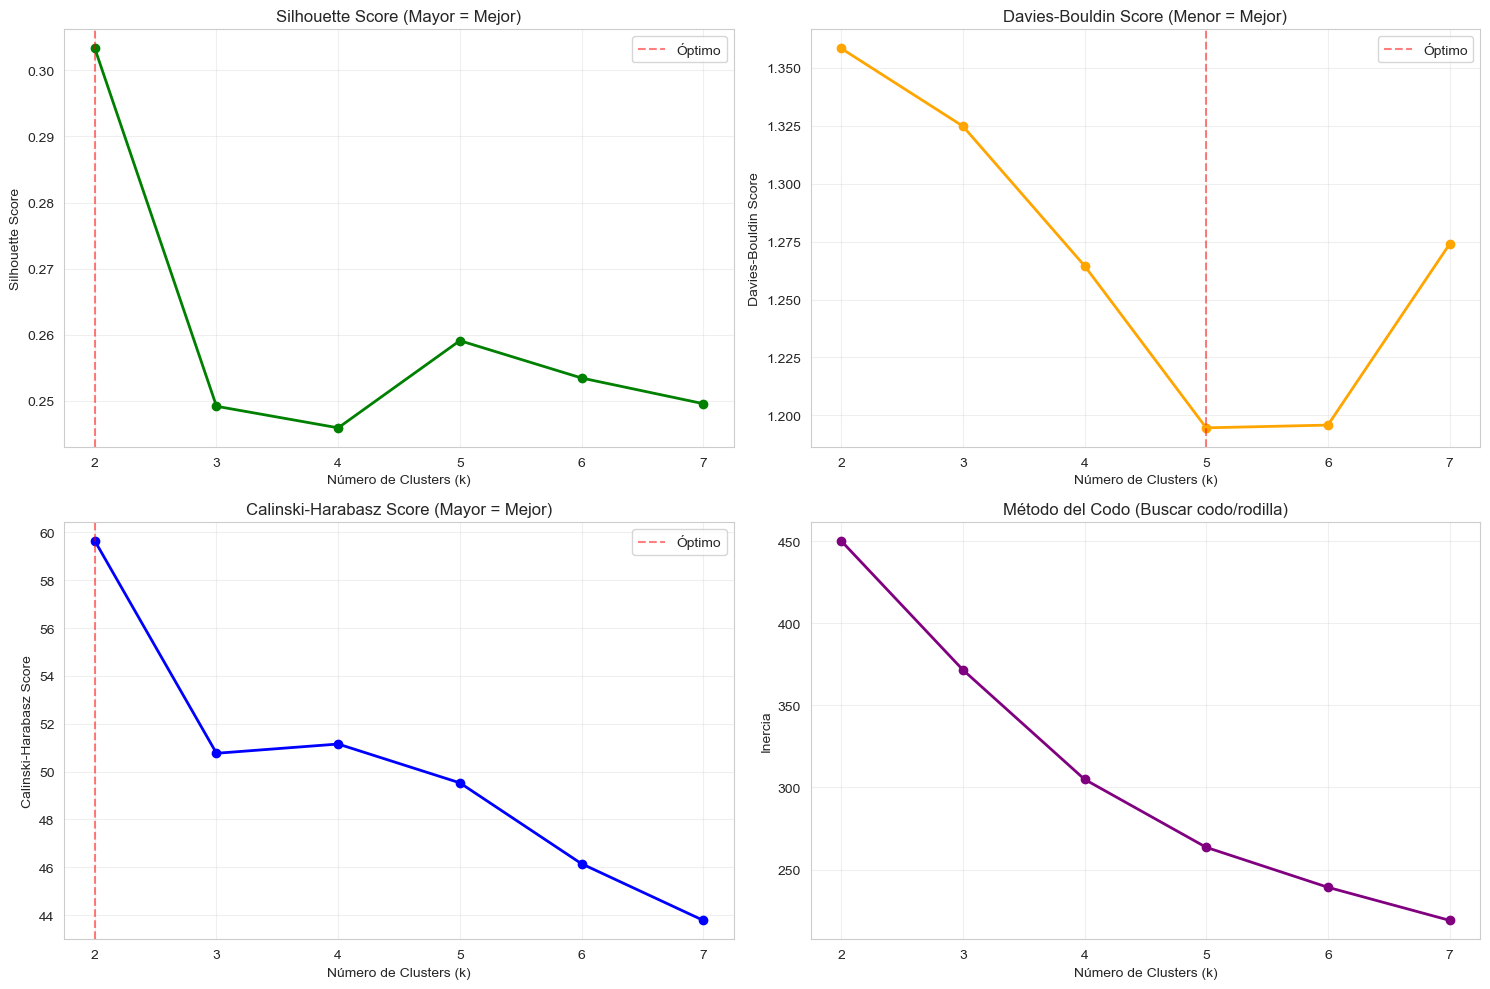

In [8]:
# =============================================================================
# PASO 8: DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS
# =============================================================================


print("\n🔍 BUSCANDO NÚMERO ÓPTIMO DE CLUSTERS...")

def evaluar_numero_clusters(X_scaled, k_range):
    """
    Evalúa diferentes números de clusters usando múltiples métricas
    """
    resultados = []
    
    for k in k_range:
        try:
            # Aplicar K-Means
            kmeans = KMeans(
                n_clusters=k, 
                random_state=CONFIG['clustering']['random_state'],
                n_init=CONFIG['clustering']['n_init']
            )
            labels = kmeans.fit_predict(X_scaled)
            
            # Calcular métricas solo si hay más de un cluster
            if len(set(labels)) > 1:
                silhouette = silhouette_score(X_scaled, labels)
                davies_bouldin = davies_bouldin_score(X_scaled, labels)
                calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
            else:
                silhouette = 0
                davies_bouldin = 10
                calinski_harabasz = 0
            
            resultados.append({
                'k': k,
                'silhouette': silhouette,
                'davies_bouldin': davies_bouldin,
                'calinski_harabasz': calinski_harabasz,
                'inertia': kmeans.inertia_
            })
            
            print(f"   k={k}: Silhouette={silhouette:.3f}, DB={davies_bouldin:.3f}, CH={calinski_harabasz:.0f}")
        except Exception as e:
            print(f"   k={k}: Error - {e}")
            continue
    
    return pd.DataFrame(resultados)

# Evaluar diferentes números de clusters
df_metricas = evaluar_numero_clusters(X_scaled, CONFIG['clustering']['k_range'])

if len(df_metricas) == 0:
    print("❌ ERROR: No se pudo evaluar ningún número de clusters")
    exit()

# Visualizar métricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico 1: Silhouette Score
axes[0, 0].plot(df_metricas['k'], df_metricas['silhouette'], 'o-', color='green', linewidth=2)
axes[0, 0].set_xlabel('Número de Clusters (k)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Silhouette Score (Mayor = Mejor)')
axes[0, 0].grid(True, alpha=0.3)
if df_metricas['silhouette'].max() > 0:
    axes[0, 0].axvline(df_metricas.loc[df_metricas['silhouette'].idxmax(), 'k'], 
                       color='red', linestyle='--', alpha=0.5, label='Óptimo')
    axes[0, 0].legend()

# Gráfico 2: Davies-Bouldin Score
axes[0, 1].plot(df_metricas['k'], df_metricas['davies_bouldin'], 'o-', color='orange', linewidth=2)
axes[0, 1].set_xlabel('Número de Clusters (k)')
axes[0, 1].set_ylabel('Davies-Bouldin Score')
axes[0, 1].set_title('Davies-Bouldin Score (Menor = Mejor)')
axes[0, 1].grid(True, alpha=0.3)
if df_metricas['davies_bouldin'].min() < 10:
    axes[0, 1].axvline(df_metricas.loc[df_metricas['davies_bouldin'].idxmin(), 'k'], 
                       color='red', linestyle='--', alpha=0.5, label='Óptimo')
    axes[0, 1].legend()

# Gráfico 3: Calinski-Harabasz Score
axes[1, 0].plot(df_metricas['k'], df_metricas['calinski_harabasz'], 'o-', color='blue', linewidth=2)
axes[1, 0].set_xlabel('Número de Clusters (k)')
axes[1, 0].set_ylabel('Calinski-Harabasz Score')
axes[1, 0].set_title('Calinski-Harabasz Score (Mayor = Mejor)')
axes[1, 0].grid(True, alpha=0.3)
if df_metricas['calinski_harabasz'].max() > 0:
    axes[1, 0].axvline(df_metricas.loc[df_metricas['calinski_harabasz'].idxmax(), 'k'], 
                       color='red', linestyle='--', alpha=0.5, label='Óptimo')
    axes[1, 0].legend()

# Gráfico 4: Método del Codo (Inercia)
axes[1, 1].plot(df_metricas['k'], df_metricas['inertia'], 'o-', color='purple', linewidth=2)
axes[1, 1].set_xlabel('Número de Clusters (k)')
axes[1, 1].set_ylabel('Inercia')
axes[1, 1].set_title('Método del Codo (Buscar codo/rodilla)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('metricas_clustering.png', dpi=150, bbox_inches='tight')
print("\n✅ Gráfico guardado: 'metricas_clustering.png'")

# Decisión multi-criterio
print("\n🎯 RECOMENDACIONES POR MÉTRICA:")
if df_metricas['silhouette'].max() > 0:
    print(f"   - Mejor por Silhouette: k={df_metricas.loc[df_metricas['silhouette'].idxmax(), 'k']}")
if df_metricas['davies_bouldin'].min() < 10:
    print(f"   - Mejor por Davies-Bouldin: k={df_metricas.loc[df_metricas['davies_bouldin'].idxmin(), 'k']}")
if df_metricas['calinski_harabasz'].max() > 0:
    print(f"   - Mejor por Calinski-Harabasz: k={df_metricas.loc[df_metricas['calinski_harabasz'].idxmax(), 'k']}")

# Seleccionar k óptimo (priorizamos Silhouette)
if df_metricas['silhouette'].max() > 0:
    k_optimo = int(df_metricas.loc[df_metricas['silhouette'].idxmax(), 'k'])
else:
    # Fallback: usar el método del codo de manera simple
    inercias = df_metricas['inertia'].values
    diferencias = np.diff(inercias)
    if len(diferencias) > 0:
        k_optimo = df_metricas.loc[np.argmin(diferencias) + 1, 'k']
    else:
        k_optimo = 3

print(f"\n✅ K ÓPTIMO SELECCIONADO: {k_optimo}")
print("="*70)

In [9]:
# =============================================================================
# PASO 9: APLICAR CLUSTERING CON MÚLTIPLES ALGORITMOS
# =============================================================================


print(f"\n🤖 APLICANDO CLUSTERING CON k={k_optimo}...")

# 9.1: K-Means (método clásico)
kmeans = KMeans(
    n_clusters=k_optimo,
    random_state=CONFIG['clustering']['random_state'],
    n_init=CONFIG['clustering']['n_init']
)
df_limpio['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

if len(set(df_limpio['cluster_kmeans'])) > 1:
    silhouette_kmeans = silhouette_score(X_scaled, df_limpio['cluster_kmeans'])
else:
    silhouette_kmeans = 0

print(f"✅ K-Means aplicado - Silhouette: {silhouette_kmeans:.3f}")

# 9.2: Hierarchical Clustering (agrupa por similitud jerárquica)
hierarchical = AgglomerativeClustering(n_clusters=k_optimo, linkage='ward')
df_limpio['cluster_hierarchical'] = hierarchical.fit_predict(X_scaled)

if len(set(df_limpio['cluster_hierarchical'])) > 1:
    silhouette_hier = silhouette_score(X_scaled, df_limpio['cluster_hierarchical'])
else:
    silhouette_hier = 0

print(f"✅ Hierarchical aplicado - Silhouette: {silhouette_hier:.3f}")

# 9.3: DBSCAN (detecta grupos por densidad)
dbscan = DBSCAN(eps=0.8, min_samples=3)
df_limpio['cluster_dbscan'] = dbscan.fit_predict(X_scaled)
n_clusters_dbscan = len(set(df_limpio['cluster_dbscan'])) - (1 if -1 in df_limpio['cluster_dbscan'].values else 0)
n_ruido = (df_limpio['cluster_dbscan'] == -1).sum()
print(f"✅ DBSCAN aplicado - Clusters: {n_clusters_dbscan}, Ruido: {n_ruido}")

# Seleccionar mejor algoritmo
if silhouette_kmeans >= silhouette_hier and silhouette_kmeans > 0:
    df_limpio['cluster_final'] = df_limpio['cluster_kmeans']
    algoritmo_seleccionado = 'K-Means'
    silhouette_final = silhouette_kmeans
elif silhouette_hier > 0:
    df_limpio['cluster_final'] = df_limpio['cluster_hierarchical']
    algoritmo_seleccionado = 'Hierarchical'
    silhouette_final = silhouette_hier
else:
    df_limpio['cluster_final'] = df_limpio['cluster_kmeans']
    algoritmo_seleccionado = 'K-Means (fallback)'
    silhouette_final = 0

print(f"\n🏆 ALGORITMO SELECCIONADO: {algoritmo_seleccionado}")
print(f"   Silhouette Score: {silhouette_final:.3f}")
print("="*70)




🤖 APLICANDO CLUSTERING CON k=2...
✅ K-Means aplicado - Silhouette: 0.303
✅ Hierarchical aplicado - Silhouette: 0.232
✅ DBSCAN aplicado - Clusters: 6, Ruido: 55

🏆 ALGORITMO SELECCIONADO: K-Means
   Silhouette Score: 0.303


In [15]:
# =============================================================================
# PASO 10: INTERPRETACIÓN DE CLUSTERS
# =============================================================================


print("\n🏷️ INTERPRETANDO CLUSTERS...")

# Calcular características promedio por cluster
perfiles_clusters = df_limpio.groupby('cluster_final').agg({
    'media_pernoctaciones_mean': 'mean',
    'total_viajeros_sum': ['sum', 'mean'],
    'estancia_relativa': 'mean',
    'volumen_relativo': 'mean',
    'variabilidad_estancia': 'mean',
    'intensidad_visitas': 'mean',
    'concentracion_estacional': 'mean',
    'pais_residencia': 'count',
    'mes_mas_probable': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A'
}).round(2)

# Aplanar columnas
perfiles_clusters.columns = ['_'.join(col) if col[1] else col[0] for col in perfiles_clusters.columns]
perfiles_clusters = perfiles_clusters.rename(columns={
    'pais_residencia_count': 'n_segmentos',
    'mes_mas_probable_<lambda>': 'mes_pico'
})

print("\n📊 CARACTERÍSTICAS DE CADA CLUSTER:")
print(perfiles_clusters)

# Asignar nombres descriptivos basados en características
def asignar_nombre_inteligente(cluster_id, caracteristicas):
    """
    Asigna nombre descriptivo basado en características del cluster
    """
    row = caracteristicas.loc[cluster_id]
    
    # Evaluar estancia
    estancia = row['media_pernoctaciones_mean_mean']
    if estancia < 4:
        tipo_estancia = "Estancia Corta"
    elif estancia < 7:
        tipo_estancia = "Estancia Media"
    else:
        tipo_estancia = "Estancia Larga"
    
    # Evaluar volumen
    volumen = row['volumen_relativo_mean']
    if volumen < 0.5:
        tipo_volumen = "Nicho"
    elif volumen < 2:
        tipo_volumen = "Medio"
    else:
        tipo_volumen = "Masivo"
    
    # Evaluar estacionalidad
    concentracion = row['concentracion_estacional_mean']
    if concentracion > 0.4:
        tipo_estacional = "Muy Estacional"
    elif concentracion > 0.25:
        tipo_estacional = "Estacional"
    else:
        tipo_estacional = "Todo el Año"
    
    # Construir nombre
    nombre = f"{tipo_volumen} | {tipo_estancia} | {tipo_estacional}"
    return nombre

# Aplicar nombres
nombres_clusters = {}
for cluster_id in perfiles_clusters.index:
    nombres_clusters[cluster_id] = asignar_nombre_inteligente(cluster_id, perfiles_clusters)

df_limpio['perfil_nombre'] = df_limpio['cluster_final'].map(nombres_clusters)

print("\n🎯 PERFILES IDENTIFICADOS:")
for cluster_id, nombre in nombres_clusters.items():
    n_elementos = (df_limpio['cluster_final'] == cluster_id).sum()
    viajeros = df_limpio[df_limpio['cluster_final'] == cluster_id]['total_viajeros_sum'].sum()
    print(f"\n   Cluster {cluster_id}: {nombre}")
    print(f"      → {n_elementos} segmentos país-provincia")
    print(f"      → {viajeros:,.0f} viajeros totales")
print("="*70)



🏷️ INTERPRETANDO CLUSTERS...

📊 CARACTERÍSTICAS DE CADA CLUSTER:
               media_pernoctaciones_mean_mean  total_viajeros_sum_sum  \
cluster_final                                                           
0                                        3.96               2394733.0   
1                                        5.69               5690777.0   

               total_viajeros_sum_mean  estancia_relativa_mean  \
cluster_final                                                    
0                             23477.77                    0.84   
1                            135494.69                    1.20   

               volumen_relativo_mean  variabilidad_estancia_mean  \
cluster_final                                                      
0                               0.10                        0.75   
1                               0.58                        0.61   

               intensidad_visitas_mean  concentracion_estacional_mean  \
cluster_final                 


📊 GENERANDO VISUALIZACIONES...
✅ Gráfico guardado: 'analisis_clusters_completo.png'


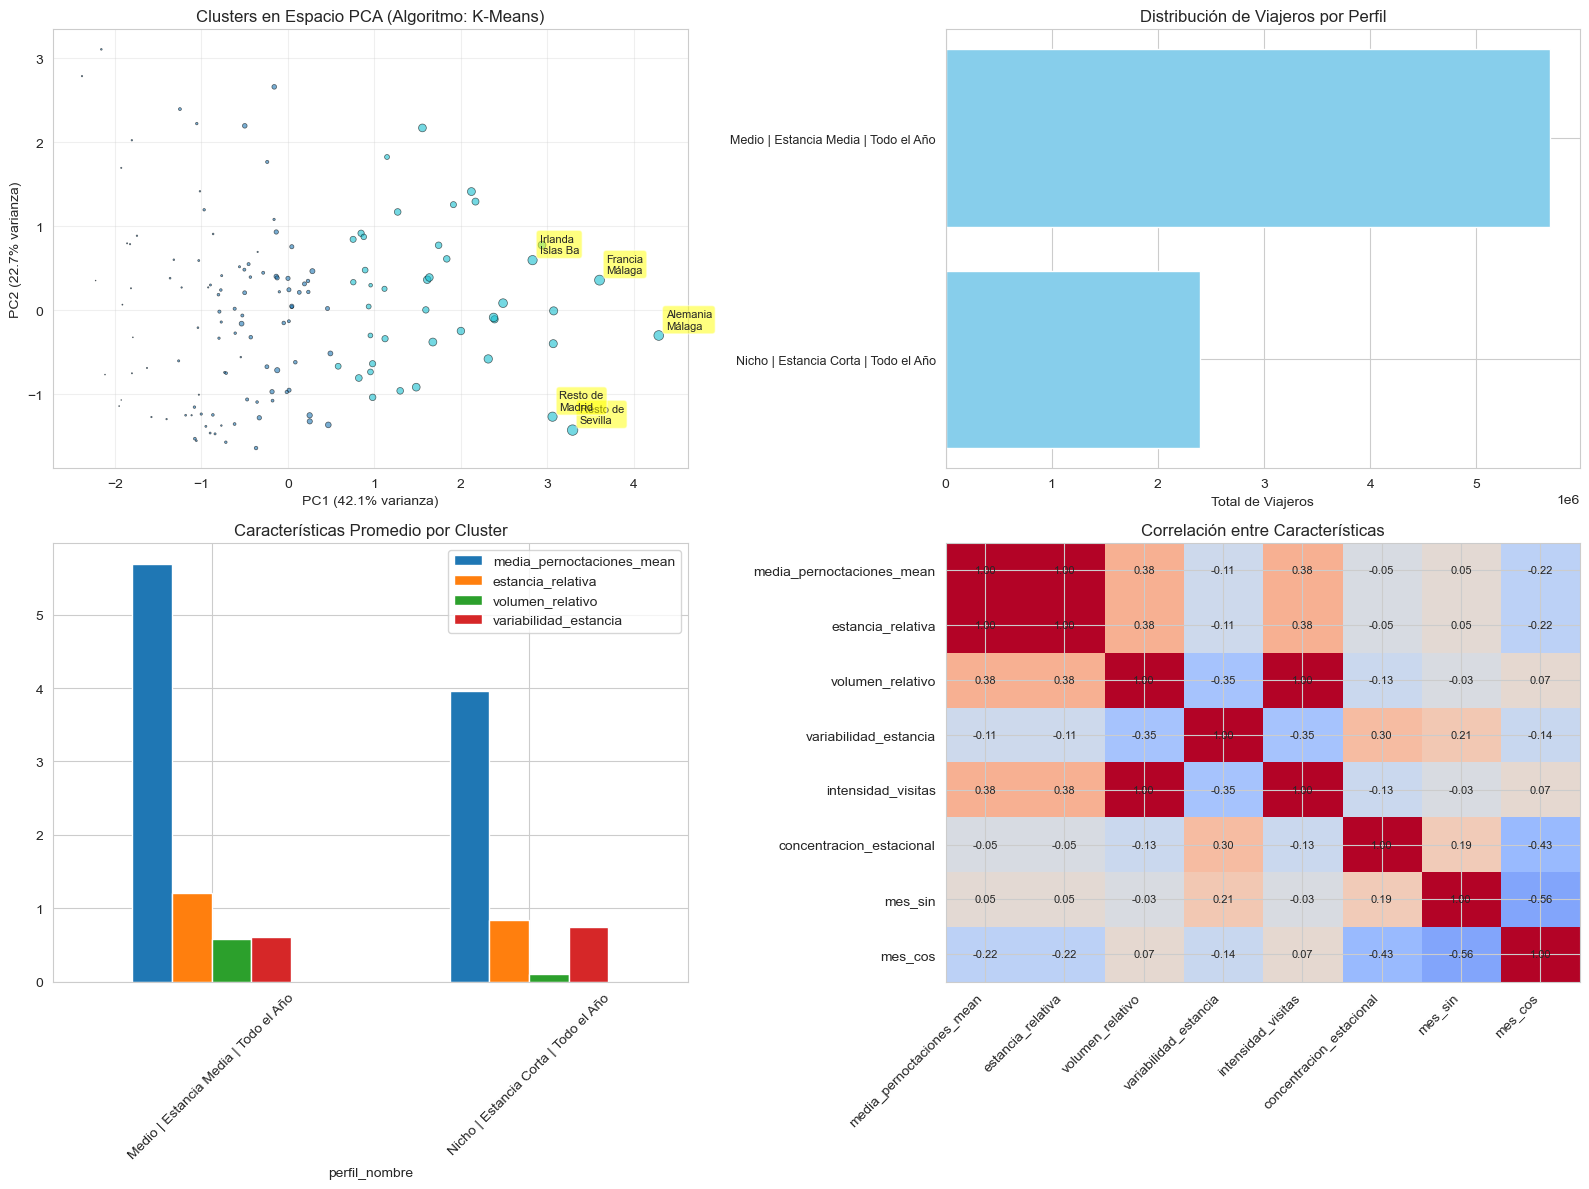

🎉 ANÁLISIS COMPLETADO


In [17]:
# =============================================================================
# PASO 11: VISUALIZACIÓN AVANZADA
# =============================================================================

print("\n📊 GENERANDO VISUALIZACIONES...")

# 11.1: PCA para visualización 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_limpio['pca1'] = X_pca[:, 0]
df_limpio['pca2'] = X_pca[:, 1]

# Gráfico principal con PCA
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Clusters en espacio PCA
scatter = axes[0, 0].scatter(
    df_limpio['pca1'], 
    df_limpio['pca2'],
    c=df_limpio['cluster_final'],
    s=df_limpio['total_viajeros_sum']/5000,
    cmap='tab10',
    alpha=0.6,
    edgecolors='black',
    linewidths=0.5
)
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
axes[0, 0].set_title(f'Clusters en Espacio PCA (Algoritmo: {algoritmo_seleccionado})')
axes[0, 0].grid(True, alpha=0.3)

# Anotar top perfiles
for _, row in df_limpio.nlargest(5, 'total_viajeros_sum').iterrows():
    axes[0, 0].annotate(
        f"{row['pais_residencia'][:8]}\n{row['provincia'][:8]}",
        (row['pca1'], row['pca2']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5)
    )

# Subplot 2: Distribución de viajeros por cluster
cluster_counts = df_limpio.groupby('perfil_nombre')['total_viajeros_sum'].sum().sort_values()
axes[0, 1].barh(range(len(cluster_counts)), cluster_counts.values, color='skyblue')
axes[0, 1].set_yticks(range(len(cluster_counts)))
axes[0, 1].set_yticklabels(cluster_counts.index, fontsize=9)
axes[0, 1].set_xlabel('Total de Viajeros')
axes[0, 1].set_title('Distribución de Viajeros por Perfil')

# Subplot 3: Características promedio por cluster
cluster_means = df_limpio.groupby('perfil_nombre')[features_disponibles[:4]].mean()
cluster_means.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Características Promedio por Cluster')
axes[1, 0].tick_params(axis='x', rotation=45)

# Subplot 4: Heatmap de correlación entre características
corr_matrix = df_limpio[features_disponibles].corr()
im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(len(features_disponibles)))
axes[1, 1].set_yticks(range(len(features_disponibles)))
axes[1, 1].set_xticklabels(features_disponibles, rotation=45, ha='right')
axes[1, 1].set_yticklabels(features_disponibles)
axes[1, 1].set_title('Correlación entre Características')

# Añadir valores de correlación
for i in range(len(features_disponibles)):
    for j in range(len(features_disponibles)):
        axes[1, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                       ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('analisis_clusters_completo.png', dpi=150, bbox_inches='tight')
print("✅ Gráfico guardado: 'analisis_clusters_completo.png'")

# Mostrar el gráfico
plt.show()

print("="*70)
print("🎉 ANÁLISIS COMPLETADO")
print("=============================================================================")
